In [1]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('data.csv')
data

,Unnamed: 0,week,tv_spend,hulu_spend,yt_spend,fb_spend,ig_spend,snap_spend,google_spend,bing_spend,total_regs,organic,tv,hulu,yt,fb,ig,snap,google,bing
0,0,0,0.469955,1.813726,0.112919,0.110406,1.338443,1.113669,0.052505,0.032142,114.953202,100.049124,1.622554,4.186071,-0.160430,0.570104,4.920102,2.580505,0.505021,0.680151
1,1,1,0.586721,1.296746,1.189538,1.727079,0.531146,0.105200,1.208417,2.593059,130.734758,99.378955,1.629731,4.768898,4.381317,6.050408,2.613322,0.774693,5.093917,6.043517
2,2,2,0.253223,2.243804,0.168885,1.552951,0.004805,2.625458,0.199648,1.202272,129.433135,100.478935,1.117387,5.583317,1.390596,7.130882,0.464256,7.810259,1.355898,4.101604
3,3,3,0.670224,0.970203,0.134036,0.682383,0.253746,0.453563,0.582416,0.259855,123.717407,102.436004,2.396015,3.958998,2.656097,3.661319,0.891071,2.454907,3.282930,1.980066
4,4,4,0.023231,0.712803,0.134583,0.688188,0.719647,0.201940,1.590692,2.932905,130.617736,102.866201,1.243197,2.556082,1.715847,3.883877,3.231609,1.944118,5.542223,7.634581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,215,0.576059,0.149967,0.605877,0.103473,0.372053,0.292975,0.097058,0.617823,178.537288,165.780565,1.526229,1.171626,2.991068,0.634257,1.261996,1.324433,1.848071,1.999044
216,216,216,0.277784,0.051608,0.790416,0.306110,2.615369,0.192774,0.715909,0.555794,190.906258,165.907101,2.580485,1.678670,2.605670,0.737837,9.959868,1.977383,3.312584,2.146661
217,217,217,1.260680,1.013545,1.327829,1.020494,0.223939,0.328874,1.117521,0.091430,192.112031,166.035644,3.891895,3.081194,4.917637,4.697607,1.222695,2.398390,4.620494,1.246472
218,218,218,0.865747,0.640820,0.173402,0.131444,0.801943,0.053964,0.774417,1.475333,186.997265,167.008168,2.944174,2.477932,1.245198,0.090911,4.074067,1.904616,2.562695,4.689504


# Modeling

In [28]:
A = data.iloc[:,2:10]
Y = data.loc[:,'tv':]
grp = [0,0,0,1,1,1,2,2]
n=220

model = pm.Model()

with model:
    ## organic 
    org0 = pm.HalfNormal('org0', sigma=100)
    org_mu = pm.HalfNormal('org_mu', sigma=10) 
    org_nu = pm.HalfNormal('org_nu', sigma=10)
    org_tau = pm.HalfNormal('org_tau', tau=org_nu, size=n)
    
    org_obs = pm.Normal('org_obs', mu=org0 + org_mu * data['week'], tau=org_tau, observed=data['organic'])
    
    ## paid 
    
    # saturation
    S_channel = pm.Normal('S_channel', mu=0, sigma=1, size=3)
    tau_s = pm.HalfNormal('tau_s', sigma=1)
    S_0 = pm.Normal('S_0', mu=S_channel[grp], tau=tau_s)
    S = pm.Deterministic('S', pm.math.exp(S_0))
    
    # tail decay
    d_channel = pm.Normal('d_channel', mu=0, sigma=1, size=3)
    tau_d = pm.HalfNormal('tau_d', sigma=1)
    d_0 = pm.Normal('d_0', mu=d_channel[grp], tau=tau_d)
    d = pm.Deterministic('d', 1 / (1 + pm.math.exp(-1 * d_0)))
    
    # diminishing returns
    l_channel = pm.Normal('l_channel', mu=0, sigma=1, size=3)
    tau_l = pm.HalfNormal('tau_l', sigma=1)
    l_0 = pm.Normal('l_0', mu=l_channel[grp], tau=tau_l)
    l = pm.Deterministic('l', 1 / (1 + pm.math.exp(-1 * l_0)))
    
    # error term
    paid_nu = pm.HalfNormal('paid_nu', sigma=10)
    paid_tau = pm.HalfNormal('paid_tau', tau=paid_nu, size=(220,8))
    
    # registered users
    paid_mu = S * pm.math.sum([d**j * (1 - pm.math.exp(-1 * l * A.shift(j).fillna(0))) for j in range(6)], axis=0)
    R = pm.Normal('R', mu=paid_mu, tau=paid_tau, observed=Y)
    
    idata = pm.sample()
    pm.sample_posterior_predictive(idata,extend_inferencedata=True)


az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [org0, org_mu, org_nu, org_tau, S_channel, tau_s, S_0, d_channel, tau_d, d_0, l_channel, tau_l, l_0, paid_nu, paid_tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1020 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
S_channel[0],1.820,0.531,0.785,2.732,0.008,0.006,5199.0,2509.0,1.0
S_channel[1],1.967,0.551,0.910,2.947,0.008,0.006,5318.0,2401.0,1.0
S_channel[2],1.516,0.629,0.281,2.626,0.008,0.006,6328.0,2430.0,1.0
S_0[0],2.352,0.075,2.218,2.500,0.001,0.001,5229.0,2847.0,1.0
S_0[1],2.498,0.078,2.345,2.643,0.001,0.001,4517.0,2776.0,1.0
...,...,...,...,...,...,...,...,...,...
l[3],0.385,0.030,0.331,0.443,0.000,0.000,4043.0,2726.0,1.0
l[4],0.383,0.027,0.329,0.430,0.000,0.000,4226.0,3063.0,1.0
l[5],0.374,0.033,0.312,0.433,0.001,0.000,3716.0,2597.0,1.0
l[6],0.515,0.038,0.448,0.588,0.001,0.000,3997.0,2925.0,1.0


# Parameter Estimates

In [33]:
idata.posterior.org0.mean()

<xarray.DataArray 'org0' ()>
array(91.69906511)

In [35]:
idata.posterior.org_mu.mean()

<xarray.DataArray 'org_mu' ()>
array(0.29737464)

In [49]:
S_values = np.array(idata.posterior.S.mean(axis=0).mean(axis=0))
lam_values = np.array(idata.posterior.l.mean(axis=0).mean(axis=0))
d_values = np.array(idata.posterior.d.mean(axis=0).mean(axis=0))

In [48]:
param_df = pd.DataFrame([S_values, lam_values, d_values])
param_df.columns = data.columns[12:]
param_df.index = ['S', 'lambda', 'd']
param_df.round(3)

,tv,hulu,yt,fb,ig,snap,google,bing
S,10.534,12.198,9.128,12.203,13.647,12.522,9.236,8.559
lambda,0.352,0.261,0.370,0.385,0.383,0.374,0.515,0.517
d,0.234,0.222,0.225,0.122,0.085,0.115,0.150,0.163


array([<AxesSubplot: xlabel='org_obs / org_obs'>,
       <AxesSubplot: xlabel='R / R'>], dtype=object)

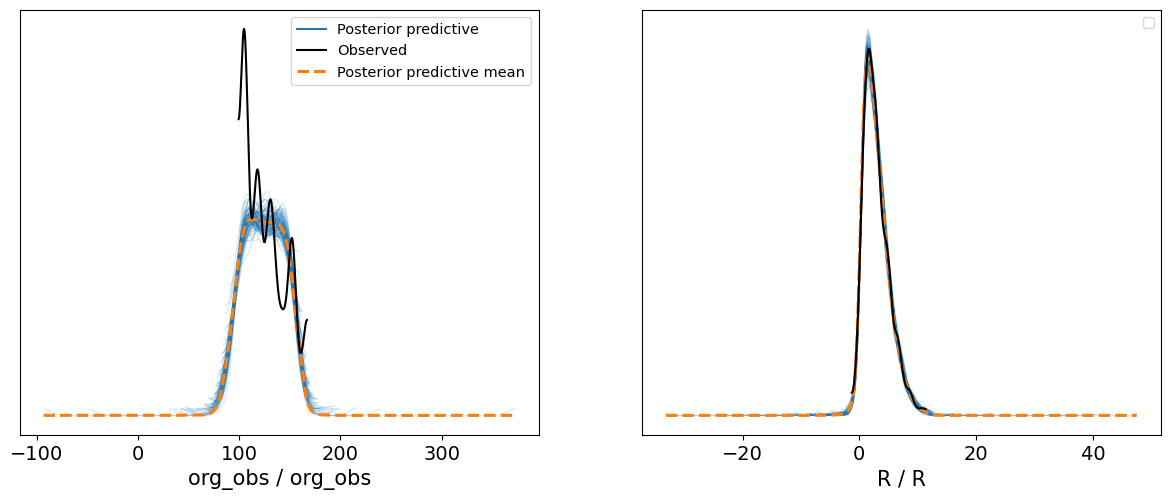

In [23]:
az.plot_ppc(idata, num_pp_samples=100)

# cf) frequentist - organic

In [3]:
import statsmodels.api as sm
import seaborn as sns

freq_model = sm.OLS(data['organic'], sm.add_constant(data['week']))
results = freq_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                organic   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     4132.
Date:                Mon, 07 Nov 2022   Prob (F-statistic):          1.09e-143
Time:                        11:34:22   Log-Likelihood:                -626.87
No. Observations:                 220   AIC:                             1258.
Df Residuals:                     218   BIC:                             1265.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.0306      0.564    166.608      0.000      92.918      95.143
week           0.2866      0.004     64.282      0.000       0.278       0.295
==============================================================================
Omnibus:                       26.048   Durbin-Watson:                   0.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.606
Skew:                           0.943   Prob(JB):                     8.31e-08
Kurtosis:                       3.054   Cond. No.                         252.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot: >

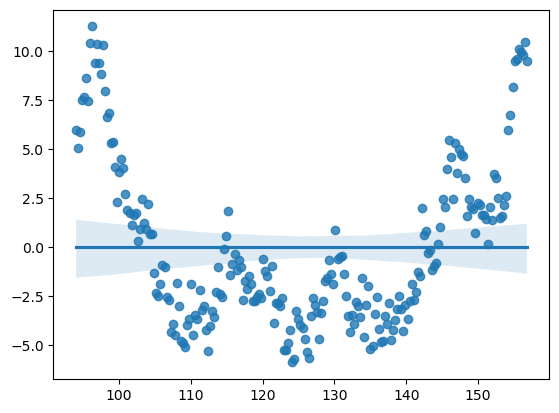

In [4]:
sns.regplot(x=results.fittedvalues, y=results.resid)

We can see why we needed a heteroskedastic model for organic registrations - the residuals clearly depict a pattern. 